<a href="https://colab.research.google.com/github/lmtoan/seismic-front-prop/blob/main/seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install --upgrade azure-storage-blob
!pip install obspy

### DO NOT PROCEED. RESTART RUNTIME NOW! https://github.com/obspy/obspy/issues/2547#issuecomment-583123449

# Setup

In [ ]:
from getpass import getpass
account_name = 'nanometricstransfer'
account_key = getpass('Key: ')

Key: ··········


In [ ]:
# Source: https://www.quickprogrammingtips.com/azure/how-to-download-blobs-from-azure-storage-using-python.html

import os
import re
from azure.storage.blob import BlobServiceClient, BlobClient
from azure.storage.blob import ContentSettings, ContainerClient
 
# IMPORTANT: Replace connection string with your storage account connection string
# Usually starts with DefaultEndpointsProtocol=https;...
MY_CONNECTION_STRING = "DefaultEndpointsProtocol=https;AccountName=%s;AccountKey=%s" % (account_name, account_key)
 
# Replace with blob container
MY_BLOB_CONTAINER = "nanometricstransfer"
 
class AzureBlobFileDownloader:
    def __init__(self):
        print("Intializing AzureBlobFileDownloader")
        # Initialize the connection to Azure storage account
        self.blob_service_client =  BlobServiceClient.from_connection_string(MY_CONNECTION_STRING)
        self.my_container = self.blob_service_client.get_container_client(MY_BLOB_CONTAINER)

    def save_blob(self, file_name, file_content):
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name, "wb") as f:
            f.write(file_content)

    def download(self, datetag, channel_tag=None):
        prefix = os.path.join('seed_files', datetag, 'EY.CH')
        all_blobs = self.my_container.list_blobs(name_starts_with=prefix)
        outpaths = []
        for blob in all_blobs:
            if channel_tag and channel_tag not in blob.name: continue # Filter for nametag
            file_name = blob.name + '.mseed'
            if os.path.exists(file_name):
                print(file_name + " existed")
            else:
                bytes = self.my_container.get_blob_client(blob).download_blob().readall()
                self.save_blob(file_name, bytes)
                print(file_name + " downloaded")
            outpaths.append(file_name)
        return outpaths
 
# Initialize class and upload files
azure_blob_file_downloader = AzureBlobFileDownloader()
data_paths = azure_blob_file_downloader.download(datetag='2019-09/2019-09-10/', channel_tag='CH02A.00.HH')

Intializing AzureBlobFileDownloader
seed_files/2019-09/2019-09-10/EY.CH02A.00.HHE.2019.253.mseed downloaded
seed_files/2019-09/2019-09-10/EY.CH02A.00.HHN.2019.253.mseed downloaded
seed_files/2019-09/2019-09-10/EY.CH02A.00.HHZ.2019.253.mseed downloaded


# Analysis

In [ ]:
from obspy import read
import matplotlib.pyplot as plt

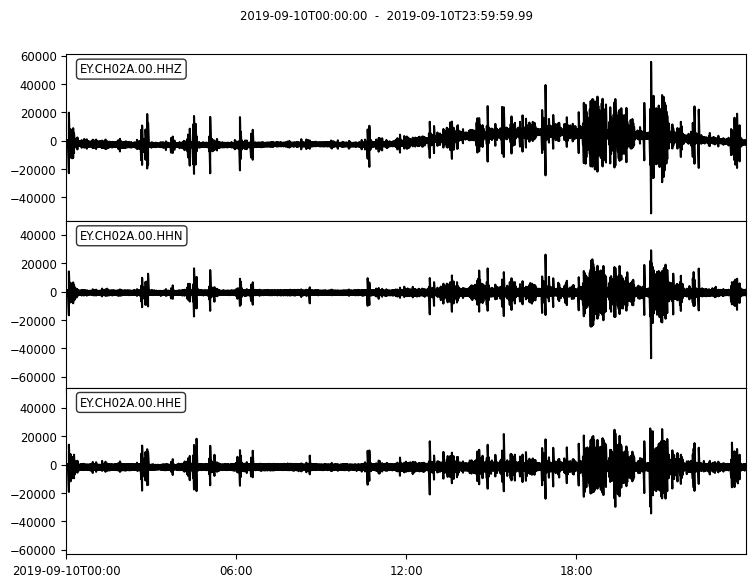

In [ ]:
threechannels = read(data_paths[0])
for path in data_paths[1:]:
    threechannels += read(path)
threechannels.plot(size=(800, 600))
plt.show()

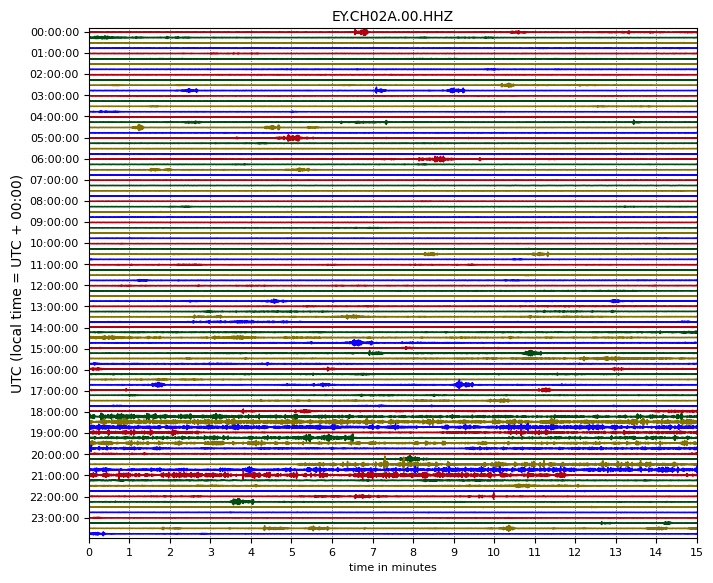

In [ ]:
singlechannel = threechannels[-1]
singlechannel.plot(type='dayplot', size=(800, 600))
plt.show()

/usr/local/lib/python3.6/dist-packages/obspy/imaging/waveform.py:511: UserWarning: Could not download the events because of 'FDSNException: Bad request. If you think your request was valid please contact the developers.
Detailed response of server:

Error 400: unknown : Cannot send body with 204
Request:
/fdsnws/event/1/query?starttime=2019-09-10T00%3A00%3A00.000000&endtime=2019-09-10T23%3A59%3A59.990000&minmagnitude=6.5
Request Submitted:
2020-10-15T15:40:20.950116Z
Service version:
fdsnws-event: v 1.1.0'.
  warnings.warn(msg)


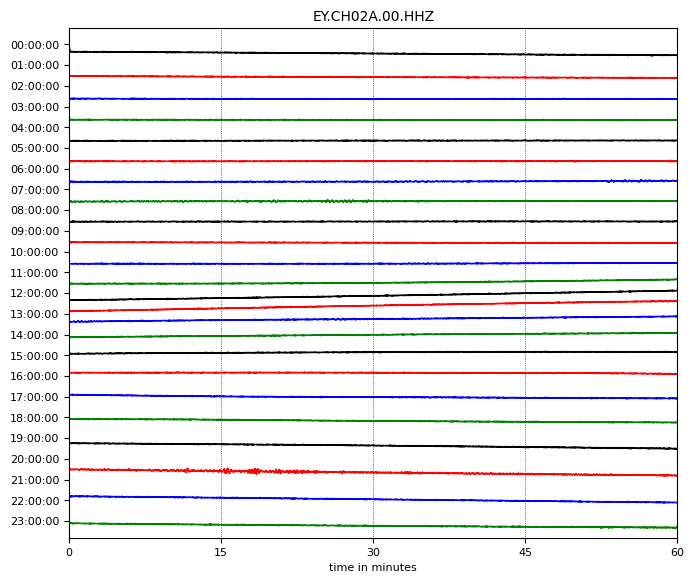

In [ ]:
singlechannel.filter("lowpass", freq=0.1, corners=2)
singlechannel.plot(type="dayplot", interval=60, right_vertical_labels=False,
         vertical_scaling_range=5e3, one_tick_per_line=True,
         color=['k', 'r', 'b', 'g'], show_y_UTC_label=False,
         events={'min_magnitude': 6.5})
plt.show()

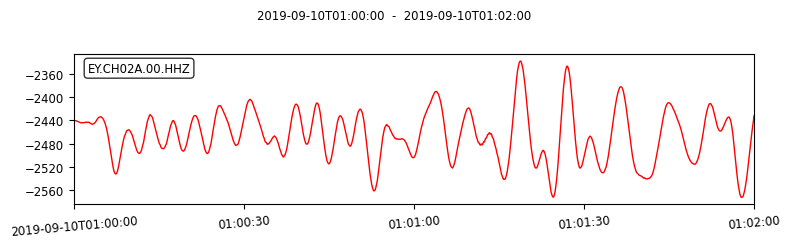

In [ ]:
dt = singlechannel.stats.starttime
singlechannel.plot(color='red', number_of_ticks=7,
                   tick_rotation=5, tick_format='%I:%M %p',
                   starttime=dt + 60*60, endtime=dt + 60*60 + 120)
plt.show()